# Introduction

In this part of the project, I'm going to develop ML models created in the previous part.

## Loading data

In [1]:
import pandas as pd
import os

def read_data(file_path: str) -> pd.DataFrame:
    if not os.path.isfile(file_path):
        raise Exception(f'File {file_path} doesn\'t exist')
    else:
        data = pd.read_csv(file_path,
                           usecols=['sofifa_id',
                                    'short_name',
                                    'player_positions',
                                    'overall',
                                    'potential',
                                    'value_eur',
                                    'wage_eur',
                                    'age',
                                    'height_cm',
                                    'weight_kg',
                                    'club_name',
                                    'league_name',
                                    'nationality_name',
                                    'preferred_foot',
                                    'pace',
                                    'shooting',
                                    'passing',
                                    'dribbling',
                                    'defending',
                                    'physic'])
        print('File loaded succesfully')

    data.set_index(['sofifa_id', 'short_name'], inplace=True)
    data['player_positions'] = data['player_positions'].apply(lambda x: x.split(', '))
    return data

df = read_data("players_22.csv")

File loaded succesfully


In [2]:
X = df[['overall', 'potential', 'age', 'wage_eur']].values
y = df['value_eur'].values

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

y_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

y = y_pipeline.fit_transform(y.reshape(-1, 1)).ravel()

## Defining base model

In [4]:
import numpy as np
from sklearn.utils import shuffle

class GradientDescentLinearRegression:
    def __init__(self, lr=0.01, n_epochs=100, batch_size=32):
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.theta = None

    def fit(self, X, y, X_val=None, y_val=None):
        self.train_costs = []
        self.val_costs = []
        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n + 1, 1))

        if X_val is not None and y_val is not None:
            X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
            y_val = y_val.reshape(-1, 1)

        for epoch in range(self.n_epochs):
            X_shuffled, y_shuffled = shuffle(X_b, y)
            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                y_pred = X_batch @ self.theta
                error = y_pred - y_batch
                grad = (2 / y_batch.shape[0]) * (X_batch.T @ error)
                self.theta -= self.lr * grad

            train_pred = X_b @ self.theta
            train_loss = np.mean((train_pred - y)**2)
            self.train_costs.append(train_loss)

            if X_val is not None and y_val is not None:
                val_pred = X_val_b @ self.theta
                val_loss = np.mean((val_pred - y_val)**2)
                self.val_costs.append(val_loss)

        self.fitted_ = True
        return self

    def predict(self, X):
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        return (X_b @ self.theta).ravel()

# Cross validation

In [5]:
import numpy as np
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=3, shuffle=True, random_state=42)
kfold_results = []

regression_gd_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regression', GradientDescentLinearRegression(lr=0.01, batch_size=64))
])

result_df = pd.DataFrame()

for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

    regression_gd_pipeline.fit(X_train, y_train)

    assert not np.any(np.isnan(y_train)), "y_train ma NaN!"

    y_pred = regression_gd_pipeline.predict(X_test)

    result = mean_squared_error(y_true=y_test,
                                y_pred=y_pred)
    
    kfold_results.append(result)

In [6]:
result_df = pd.DataFrame({
    'Fold': np.arange(1, len(kfold_results) + 1),
    'MSE': kfold_results
})


result_df.loc['Średnia'] = ['-', np.mean(kfold_results)]
display(result_df)

,Fold,MSE
0,1,0.326687
1,2,0.272890
2,3,0.297507
Średnia,-,0.299028


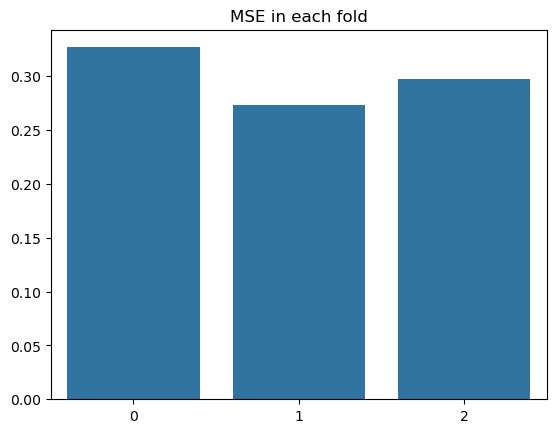

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=kfold_results)
plt.title("MSE in each fold")
plt.show()

# Over- and Underfit check using Polynomial features

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

degrees = [1, 2, 5, 10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_costs = []
val_costs = []

for degree in degrees:
    preprocessing = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler())
    ])

    X_train_proc = preprocessing.fit_transform(X_train)
    X_test_proc = preprocessing.transform(X_test)

    model = GradientDescentLinearRegression(lr=0.0001, batch_size=512, n_epochs=500)
    model.fit(X_train_proc, y_train, X_val=X_test_proc, y_val=y_test)

    train_costs.append(model.train_costs)
    val_costs.append(model.val_costs)

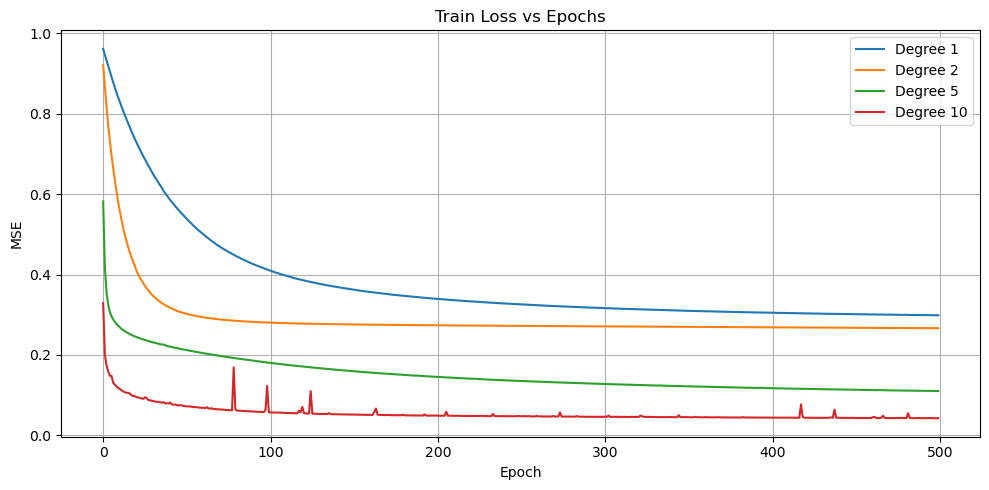

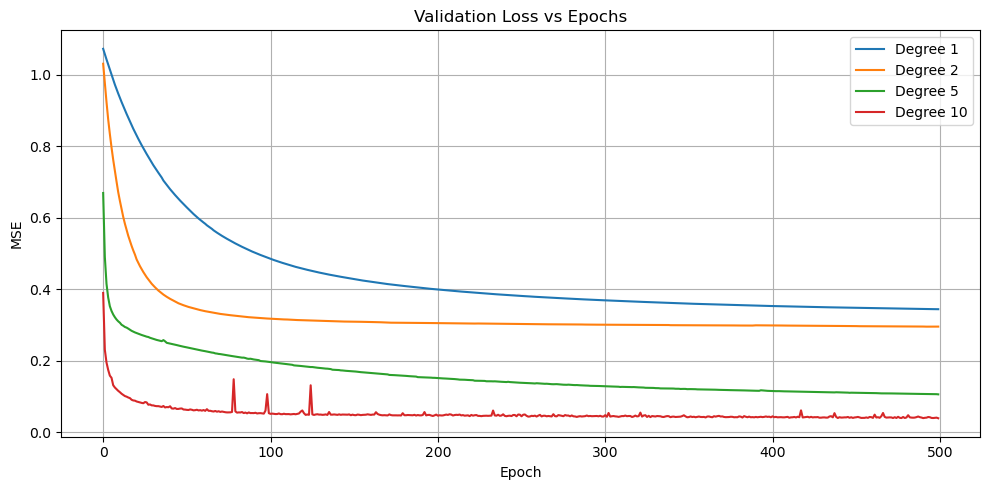

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i, costs in enumerate(train_costs):
    plt.plot(costs, label=f'Degree {degrees[i]}')
plt.title("Train Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, costs in enumerate(val_costs):
    if costs:
        plt.plot(costs, label=f'Degree {degrees[i]}')
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Adding regularization (L2 and L1)

## L1 Lassso regularization model

In [10]:
import numpy as np
from sklearn.utils import shuffle

class GradientDescentLinearRegressionL1:
    def __init__(self, lr=0.01, n_epochs=100, batch_size=32, l1=0.0):
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.l1 = l1
        self.theta = None

    def fit(self, X, y, X_val=None, y_val=None):
        self.train_costs = []
        self.val_costs = []

        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n + 1, 1))

        if X_val is not None and y_val is not None:
            X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
            y_val = y_val.reshape(-1, 1)

        for epoch in range(self.n_epochs):
            X_shuffled, y_shuffled = shuffle(X_b, y)

            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = X_batch @ self.theta
                error = y_pred - y_batch

                reg_term = self.l1 * np.r_[[[0]], np.sign(self.theta[1:])]

                grad = (2 / y_batch.shape[0]) * (X_batch.T @ error) + reg_term
                self.theta -= self.lr * grad

            train_pred = X_b @ self.theta
            mse_train = np.mean((train_pred - y) ** 2)
            reg_cost = self.l1 * np.sum(np.abs(self.theta[1:]))
            self.train_costs.append(mse_train + reg_cost)

            if X_val is not None and y_val is not None:
                val_pred = X_val_b @ self.theta
                mse_val = np.mean((val_pred - y_val) ** 2)
                reg_val_cost = self.l1 * np.sum(np.abs(self.theta[1:]))
                self.val_costs.append(mse_val + reg_val_cost)

        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, 'fitted_'):
            raise ValueError("Model nie został jeszcze dopasowany.")
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        return (X_b @ self.theta).ravel()


## L2 Ridge regularization

In [11]:

class GradientDescentLinearRegressionL2:
    def __init__(self, lr=0.01, n_epochs=250, batch_size=256, l2=0.0):
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.l2 = l2
        self.theta = None

    def fit(self, X, y, X_val=None, y_val=None):
        self.train_costs = []
        self.val_costs = []

        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n + 1, 1))

        if X_val is not None and y_val is not None:
            X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
            y_val = y_val.reshape(-1, 1)

        for epoch in range(self.n_epochs):
            X_shuffled, y_shuffled = shuffle(X_b, y)

            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = X_batch @ self.theta
                error = y_pred - y_batch

                reg_term = self.l2 * np.r_[[[0]], self.theta[1:]]

                grad = (2 / y_batch.shape[0]) * (X_batch.T @ error) + reg_term
                self.theta -= self.lr * grad

            train_pred = X_b @ self.theta
            mse_train = np.mean((train_pred - y) ** 2)
            reg_cost = self.l2 * np.sum(self.theta[1:] ** 2)
            self.train_costs.append(mse_train + reg_cost)

            if X_val is not None and y_val is not None:
                val_pred = X_val_b @ self.theta
                mse_val = np.mean((val_pred - y_val) ** 2)
                reg_val_cost = self.l2 * np.sum(self.theta[1:] ** 2)
                self.val_costs.append(mse_val + reg_val_cost)

        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, 'fitted_'):
            raise ValueError("Model nie został jeszcze dopasowany.")
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        return (X_b @ self.theta).ravel()

## Results comparison

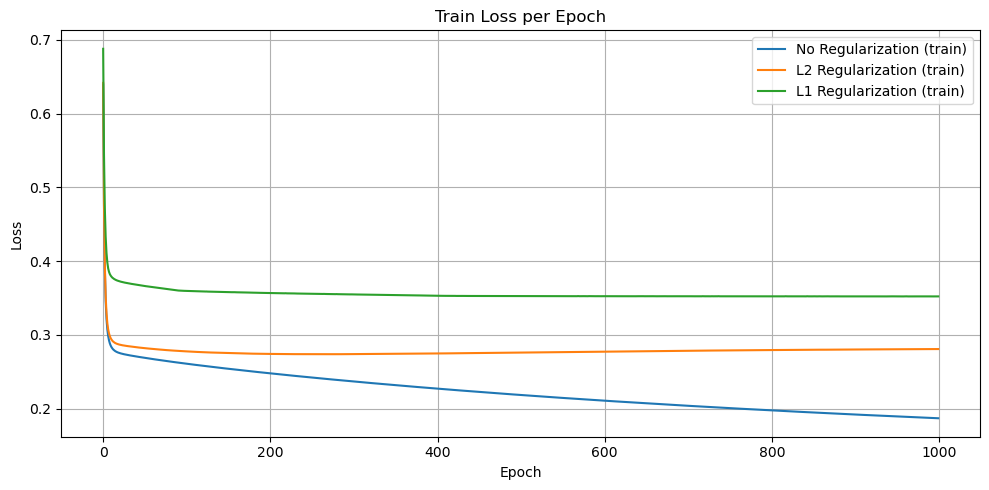

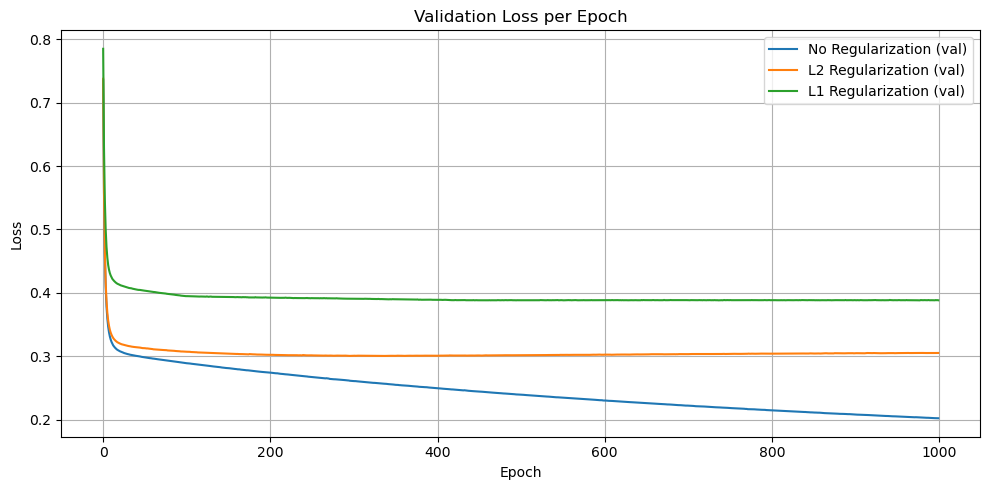

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

X_train_proc = preprocessing.fit_transform(X_train)
X_test_proc = preprocessing.transform(X_test)

params = dict(lr=0.0001, n_epochs=1000, batch_size=64)

models = {
    "No Regularization": GradientDescentLinearRegression(**params),
    "L2 Regularization": GradientDescentLinearRegressionL2(**params, l2=0.1),
    "L1 Regularization": GradientDescentLinearRegressionL1(**params, l1=0.1)
}

results = {}
for name, model in models.items():
    model.fit(X_train_proc, y_train, X_val=X_test_proc, y_val=y_test)
    results[name] = {
        "train": model.train_costs,
        "val": model.val_costs
    }

plt.figure(figsize=(10, 5))
for name in results:
    plt.plot(results[name]["train"], label=f"{name} (train)")
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name in results:
    plt.plot(results[name]["val"], label=f"{name} (val)")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

n_features = X.shape[1]
feature_names = ['bias'] + preprocessing.named_steps['poly'].get_feature_names_out([f'x{i}' for i in range(n_features)]).tolist()

weights_df = pd.DataFrame({
    'Cecha': feature_names,
    'Wagi (No Reg)': models["No Regularization"].theta.ravel(),
    'Wagi (L2)': models["L2 Regularization"].theta.ravel(),
    'Wagi (L1)': models["L1 Regularization"].theta.ravel()
})

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MSE': [model.train_costs[-1] for model in models.values()],
    'Validation MSE': [model.val_costs[-1] for model in models.values()]
})

display(weights_df)
display(results_df)


,Cecha,Wagi (No Reg),Wagi (L2),Wagi (L1)
0,bias,0.000137,0.000133,0.000148
1,x0,-0.243101,-0.038439,0.000110
2,x1,-0.317719,-0.119829,0.000388
3,x2,0.078388,0.012567,-0.000129
4,x3,0.017182,0.100930,0.000630
5,x0^2,0.370649,0.199698,0.000490
6,x0 x1,0.341827,0.177996,0.084109
7,x0 x2,-0.150442,-0.070187,0.000002
8,x0 x3,0.626615,0.336980,0.248465
9,x1^2,0.237225,0.108745,0.076334


,Model,Train MSE,Validation MSE
0,No Regularization,0.186863,0.202088
1,L2 Regularization,0.280696,0.305091
2,L1 Regularization,0.352104,0.388239


# Balancing the dataset

Now I will convert target column to binary version, to use Under- and Oversampling.

In [14]:
y_binary = np.where(y >= np.percentile(y, 98), 1, 0)

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_trans = scaler.fit_transform(imputer.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_binary, test_size=0.2, random_state=42)

In [15]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = undersampler.fit_resample(X_train, y_train)

models = {
    "Logistic - original": (LogisticRegression(max_iter=1000), X_train, y_train),
    "Logistic - SMOTE": (LogisticRegression(max_iter=1000), X_train_sm, y_train_sm),
    "Logistic - undersample": (LogisticRegression(max_iter=1000), X_train_rus, y_train_rus)
}

for name, (model, X_tr, y_tr) in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_test)

    print(f"\n>>> {name}")
    print(classification_report(y_test, y_pred, digits=3))


>>> Logistic - original
              precision    recall  f1-score   support

           0      0.998     0.998     0.998      3769
           1      0.887     0.899     0.893        79

    accuracy                          0.996      3848
   macro avg      0.943     0.948     0.945      3848
weighted avg      0.996     0.996     0.996      3848


>>> Logistic - SMOTE
              precision    recall  f1-score   support

           0      1.000     0.990     0.995      3769
           1      0.687     1.000     0.814        79

    accuracy                          0.991      3848
   macro avg      0.843     0.995     0.905      3848
weighted avg      0.994     0.991     0.991      3848


>>> Logistic - undersample
              precision    recall  f1-score   support

           0      1.000     0.974     0.987      3769
           1      0.449     1.000     0.620        79

    accuracy                          0.975      3848
   macro avg      0.724     0.987     0.803      3848

# Hyperparameters optimalization

In [16]:
transform_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_trans = transform_pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train.ravel())

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100]},
             scoring='neg_mean_squared_error')

In [18]:
from sklearn.svm import LinearSVR

svr = LinearSVR(max_iter=50000)

param_grid_svr = {
    'C': [5, 10, 15],
    'epsilon': [0.001, 0.01, 0.1, 1],
}

grid_svr = GridSearchCV(svr, param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train, y_train.ravel())


/opt/miniconda3/envs/MSiD/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVR(max_iter=50000), n_jobs=-1,
             param_grid={'C': [5, 10, 15], 'epsilon': [0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error')

In [19]:
print("Random forest params:")
print("Best RF params:", grid_rf.best_params_)
print("Best RF MSE:", -grid_rf.best_score_)
print("---")
print("SVR params")
print("Best SVR params:", grid_svr.best_params_)
print("Best SVR MSE:", -grid_svr.best_score_)


Random forest params:
Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best RF MSE: 0.025354829258239297
---
SVR params
Best SVR params: {'C': 15, 'epsilon': 1}
Best SVR MSE: 0.3640908013928235


# Ensemble methods

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

transform_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_trans = transform_pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

base_models = [
    ('linreg', LinearRegression()),
    ('dtr', DecisionTreeRegressor()),
    ('svr', LinearSVR(max_iter=5000))
]

## Voting Regressor

In [33]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(estimators=base_models)

voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_test)

voting_mse = mean_squared_error(y_test, y_pred)

## Stacking regressor

In [34]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

final_estimator=RidgeCV()

stacking_reg = StackingRegressor(estimators=base_models,
                                 final_estimator=final_estimator,
                                 cv=3,
                                 passthrough=False)
stacking_reg.fit(X_train, y_train)
y_pred = stacking_reg.predict(X_test)

stacking_mse = mean_squared_error(y_test, y_pred)

In [35]:
print(f"MSE - Voting regressor:\t\t{voting_mse}")
print(f"MSE - Stacking regressor:\t{stacking_mse}")

MSE - Voting regressor:		0.1898647769776816
MSE - Stacking regressor:	0.05779359544008648


In [36]:
results = [('VotingRegressor', voting_mse), ("StackingRegressor",stacking_mse)]
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    results.append((model.__class__.__name__, mse))

df = pd.DataFrame(sorted(results, key=lambda x: x[1]), columns=['Model', 'MSE'])

display(df)

,Model,MSE
0,StackingRegressor,0.057794
1,DecisionTreeRegressor,0.073431
2,VotingRegressor,0.189865
3,LinearRegression,0.327173
4,LinearSVR,0.488748


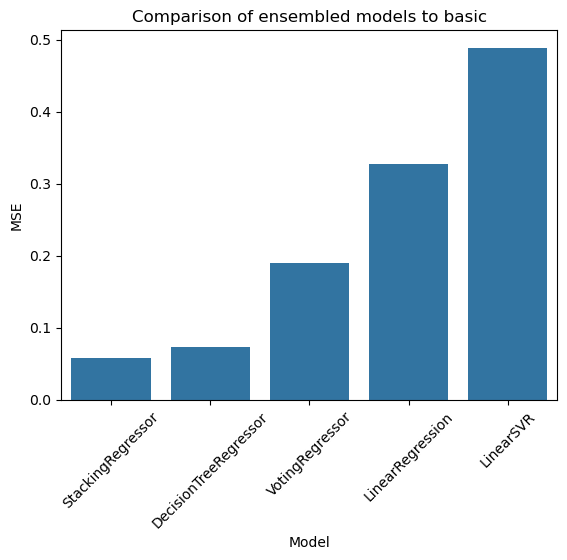

In [37]:
sns.barplot(x=df['Model'], y=df['MSE'])
plt.xticks(rotation=45)
plt.title("Comparison of ensembled models to basic")
plt.show()

## Mixture of experts

In [38]:
import numpy as np

class MixtureOfExperts:
    def __init__(self, experts, gating_model):
        self.experts = experts
        self.gating_model = gating_model

    def fit(self, X, y):
        for expert in self.experts:
            expert.fit(X, y)
        
        expert_preds = np.column_stack([expert.predict(X) for expert in self.experts])
        best_expert_idx = np.argmin(np.abs(expert_preds - y.reshape(-1, 1)), axis=1)

        self.gating_model.fit(X, best_expert_idx)
        return self

    def predict(self, X):
        expert_preds = np.column_stack([expert.predict(X) for expert in self.experts])
        gating_probs = self.gating_model.predict_proba(X)

        weighted_preds = np.sum(gating_probs * expert_preds, axis=1)
        return weighted_preds


In [39]:
moe = MixtureOfExperts(experts=[model for name, model in base_models],
                       gating_model=LogisticRegression())
moe.fit(X_train, y_train)

y_pred = moe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mixture of Experts MSE: {mse:.4f}")
results.append(('Mixture of experts', mse))
df = pd.DataFrame(sorted(results, key=lambda x: x[1]), columns=['Model', 'MSE'])
display(df)

Mixture of Experts MSE: 0.0539


,Model,MSE
0,Mixture of experts,0.053924
1,StackingRegressor,0.057794
2,DecisionTreeRegressor,0.073431
3,VotingRegressor,0.189865
4,LinearRegression,0.327173
5,LinearSVR,0.488748


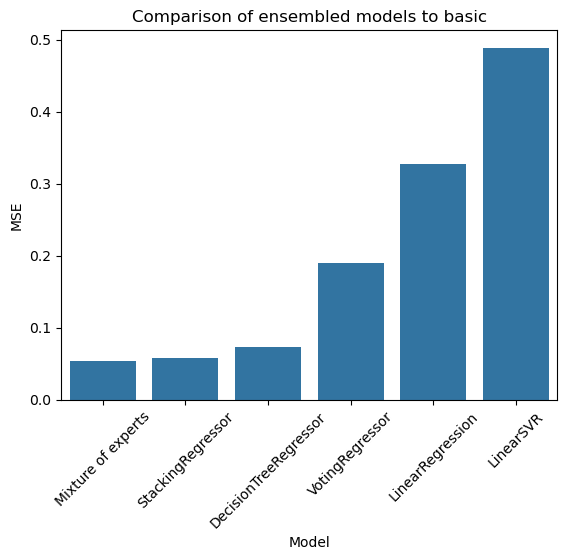

In [40]:
sns.barplot(x=df['Model'], y=df['MSE'])
plt.xticks(rotation=45)
plt.title("Comparison of ensembled models to basic")
plt.show()